#### Import required libraries 

In [112]:
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler 

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt     


from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler 
# import plotly.graph_objects as go


# from sklearn.ensemble import IsolationForest  

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import seaborn as sns #visualisation


In [113]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 

#### Read the dataset 
- integrate the data with normal and attack 

In [114]:
# import data set from the local driver 
dff=pd.read_csv('SWaT_Dataset_Normal_v0.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp') 
df=pd.read_csv('SWaT_Dataset_Attack_v0 - Copy.csv')#, parse_dates = ['Timestamp'], index_col = 'Timestamp')
frames = [dff,df] 
df_concat=pd.concat(frames) 
df_concat.head(5)   

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


#### Automatic Sensor data extraction  

In [115]:
# # select sensor data 
df1=df_concat.filter(regex='(^Time|^PIT|^AIT|^FIT|^DPI|^LIT|^Norma)',axis=1)#.head()
df1.head()
df1.shape

(946719, 27)

In [116]:
# remove the space on Normal/Attack columns 
df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')  
#To see how the data is spread betwen Attack and Normal 
print(df1.groupby('Normal/Attack')['Normal/Attack'].count())  
# Rename the col name Normal/Attack with A   
df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)
df1.head(2)  

Normal/Attack
Attack     54621
Normal    892098
Name: Normal/Attack, dtype: int64


/tmp/ipykernel_114219/2851093114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Normal/Attack'] = df1['Normal/Attack'].str.replace(' ', '')
/tmp/ipykernel_114219/2851093114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns = {'Normal/Attack':'A'}, inplace = True)


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,Normal


In [117]:
# Convert non-numeric to numeric

df1.A[df1.A== 'Normal'] = 0 
df1.A[df1.A == 'Attack'] = 1    
df1.head()

/tmp/ipykernel_114219/900075731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
/tmp/ipykernel_114219/900075731.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A== 'Normal'] = 0
/tmp/ipykernel_114219/900075731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.A[df1.A == 'Attack'] = 1
/tmp/ipykernel_114219/900075731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,22/12/2015 4:00:00 PM,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
1,22/12/2015 4:00:01 PM,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
2,22/12/2015 4:00:02 PM,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
3,22/12/2015 4:00:03 PM,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0
4,22/12/2015 4:00:04 PM,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0


In [118]:
# convert the data type to float 
df1['A'] = df1['A'].astype('float') 

/tmp/ipykernel_114219/3665295471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['A'] = df1['A'].astype('float')


In [119]:
# make the Timestamp to datetime datatype 
df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series 
df1.head() 
# # df1.shape

#df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])  

#df1.head()

/tmp/ipykernel_114219/1285722332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Timestamp'] = pd.to_datetime(df1['Timestamp']) # conveting the date time stamp to the timestamp series


,Timestamp,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
0,2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
1,2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2,2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
3,2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
4,2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [120]:
# make Timestamp feature  as index 
df1= df1.set_index('Timestamp') 
df1.head() 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.470294,261.5804,244.3284,8.19008,306.101,2.471278,20.79839,2.235275,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:01,2.457163,261.1879,244.3284,8.19008,306.101,2.468587,20.79839,2.234507,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:02,2.439548,260.9131,244.3284,8.19008,306.101,2.467305,20.84320,2.233354,327.4401,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:03,2.428338,260.2850,244.3284,8.19008,306.101,2.466536,20.84320,2.233354,327.2799,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:04,2.424815,259.8925,244.4245,8.19008,306.101,2.466536,20.84320,2.233354,327.1597,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [121]:
# df1.tail()

##### Interpolation the data with each time stamp

In [122]:
# resample the data with 5 second 
df1=df1.resample('5s').mean()
df1.interpolate(method='polynomial',order=2)
df1.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.444032,260.77178,244.34762,8.190080,306.10100,2.468048,20.825276,2.233969,327.35198,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:05,2.513980,260.59906,244.62956,8.190080,306.10100,2.467741,20.831038,2.234686,326.95144,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:10,2.641322,261.67458,244.87950,8.190080,306.05486,2.473072,20.827198,2.234302,326.47080,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:15,2.597893,261.05440,245.03330,8.190080,305.87030,2.473969,20.870094,2.235147,327.78456,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0
2015-12-22 16:00:20,2.521731,262.10636,245.44990,8.190849,305.87030,2.472970,20.836804,2.235147,328.58562,0.0,...,12.68905,0.001666,0.001409,0.001664,0.0,10.02948,0.0,4.277749,0.000256,0.0


In [123]:
# Count NaN values of whole DataFrame
nan_count = df1.isna().sum()#.sum()
print(nan_count )    

FIT101     518415
LIT101     518415
AIT201     518415
AIT202     518415
AIT203     518415
FIT201     518415
DPIT301    518415
FIT301     518415
LIT301     518415
AIT401     518415
AIT402     518415
FIT401     518415
LIT401     518415
AIT501     518415
AIT502     518415
AIT503     518415
AIT504     518415
FIT501     518415
FIT502     518415
FIT503     518415
FIT504     518415
PIT501     518415
PIT502     518415
PIT503     518415
FIT601     518415
A          518415
dtype: int64


In [124]:
df1.fillna(method = 'ffill', inplace = True)   

In [125]:
df1.shape

(707760, 26)

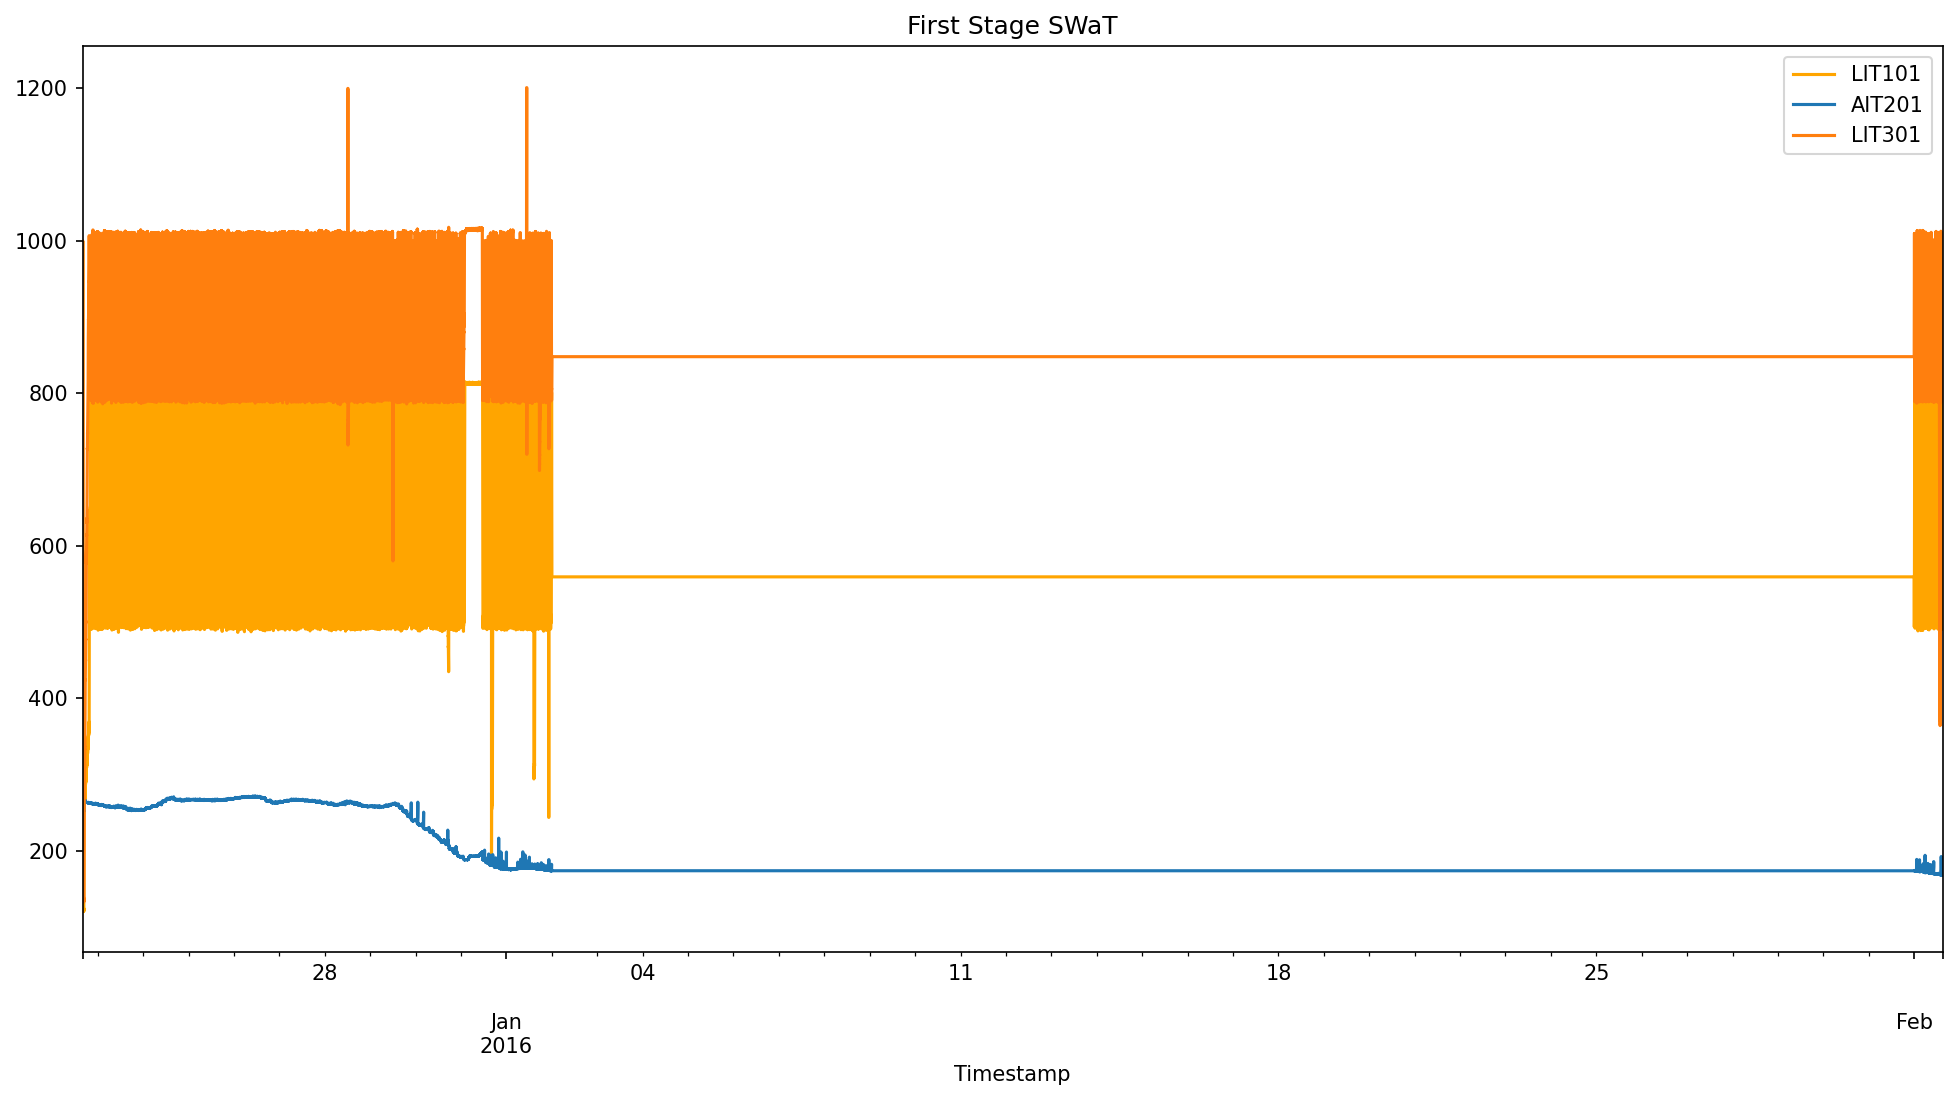

In [82]:
# code
# Visualizing The first stage with respect to time series 
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
#df1['FIT101'].plot(label='FIT101')
df1['LIT101'].plot(label='LIT101', color='orange')
df1['AIT201'].plot(label='AIT201')

df1['LIT301'].plot(label='LIT301')

# adding title to the plot
plt.title('First Stage SWaT')
# adding Label to the x-axis
plt.xlabel('Timestamp')  
# adding legend to the curve
plt.legend()  

In [83]:
# df1= df1.drop('Timestamp', axis=1) 

In [126]:
# make the class label into 2 since during sampling and interpolation it create the new class labels
df1.loc[df1['A'] >= 0.2, 'lablel'] = 1 
df1.loc[df1['A'] ==0.0, 'lablel'] = 0

In [127]:
df1

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,A,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,2.444032,260.77178,244.34762,8.190080,306.10100,2.468048,20.825276,2.233969,327.35198,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:05,2.513980,260.59906,244.62956,8.190080,306.10100,2.467741,20.831038,2.234686,326.95144,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:10,2.641322,261.67458,244.87950,8.190080,306.05486,2.473072,20.827198,2.234302,326.47080,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:15,2.597893,261.05440,245.03330,8.190080,305.87030,2.473969,20.870094,2.235147,327.78456,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
2015-12-22 16:00:20,2.521731,262.10636,245.44990,8.190849,305.87030,2.472970,20.836804,2.235147,328.58562,0.0000,...,0.001666,0.001409,0.001664,0.000000,10.02948,0.000000,4.277749,0.000256,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01 14:59:35,2.445633,519.44746,168.09790,8.643233,301.84570,2.458924,20.407838,2.197790,975.15060,148.8032,...,1.713509,1.274267,0.734885,0.308426,251.33296,0.977157,189.038100,0.000000,0.0,0.0
2016-02-01 14:59:40,2.496877,518.02650,168.09790,8.643489,301.84570,2.460898,20.376462,2.197098,976.01580,148.8032,...,1.715099,1.268349,0.734885,0.308426,251.21760,0.925896,188.909940,0.000000,0.0,0.0
2016-02-01 14:59:45,2.645230,516.64482,168.09790,8.642528,301.84570,2.461359,20.336768,2.194254,975.96774,148.8032,...,1.713714,1.275932,0.734885,0.308426,251.24966,0.925896,188.964400,0.000000,0.0,0.0


In [128]:
# fill the missing values with forward and backward of the cols 

df1=df1.fillna(method="ffill")

In [129]:
df1.isna().sum()

FIT101     0
LIT101     0
AIT201     0
AIT202     0
AIT203     0
FIT201     0
DPIT301    0
FIT301     0
LIT301     0
AIT401     0
AIT402     0
FIT401     0
LIT401     0
AIT501     0
AIT502     0
AIT503     0
AIT504     0
FIT501     0
FIT502     0
FIT503     0
FIT504     0
PIT501     0
PIT502     0
PIT503     0
FIT601     0
A          0
lablel     0
dtype: int64

#### Visualize the dataset 
-  Plotting the number of normal and Attack transactions in the dataset. 

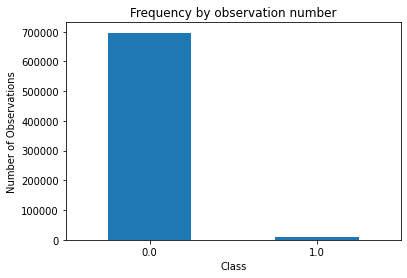

In [130]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(df1['lablel'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(df1['lablel'].unique())))#, df1.A.unique()))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");   

In [131]:
df1= df1.drop('A', axis=1)

In [132]:
# count the number of anomalies and normal data points in our dataset 
df1['lablel'].value_counts() 


0.0    696805
1.0     10955
Name: lablel, dtype: int64

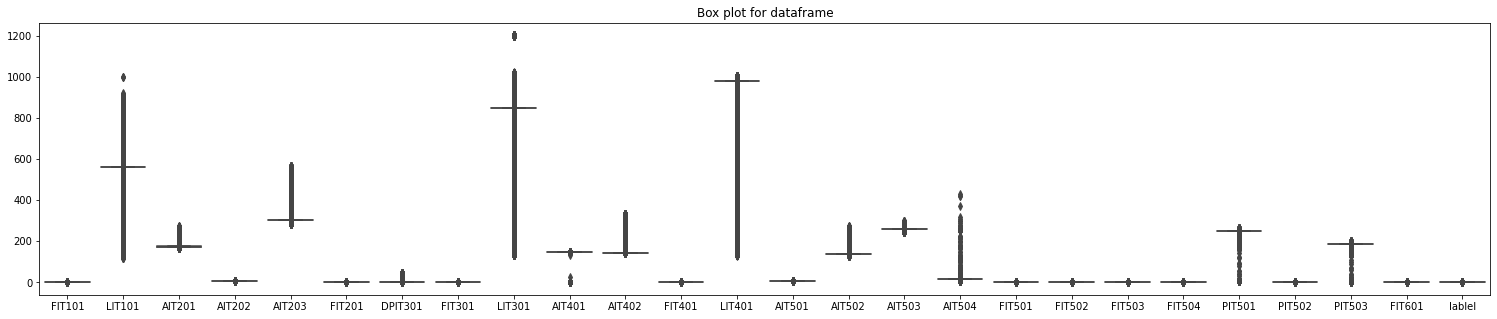

In [91]:
# checking the outlier in the data 
# sns.boxplot(data=df) 
fig = plt.figure(figsize=(26,5))
sns.boxplot(data=df1)  
# plt.xticks([1,2],['Our data', 'Hypothetical data'])
# plt.ylabel('Grade')
plt.title('Box plot for dataframe')
plt.show()  

### Normalize using Min max Scaler 

In [133]:
# # For content length, use the Min max Scalar.  
# from sklearn.preprocessing import MinMaxScaler 

con_feats = ['FIT101','LIT101','AIT201','AIT202','AIT203','FIT201','DPIT301','FIT301','FIT301','LIT301','AIT401',
            'AIT402','FIT401','LIT401','AIT501','AIT502','AIT503','AIT504','FIT501','FIT502','FIT503','FIT504',
            'PIT501','PIT502','PIT503','FIT601'] 
scaler = MinMaxScaler() 
df1[con_feats] = scaler.fit_transform(df1[con_feats])
df1.head(5)

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,0.894293,0.159184,0.731315,0.732954,0.073596,0.873447,0.462669,0.948655,0.181982,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:05,0.919888,0.158988,0.734017,0.732954,0.073596,0.873338,0.462797,0.948960,0.181607,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:10,0.966483,0.160211,0.736412,0.732954,0.073433,0.875225,0.462712,0.948797,0.181156,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:15,0.950592,0.159506,0.737886,0.732954,0.072778,0.875542,0.463665,0.949156,0.182387,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:20,0.922724,0.160702,0.741878,0.733212,0.072778,0.875188,0.462925,0.949156,0.183137,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0


### Plot Collective Anomalies 

In [93]:
# import plotly.express as px
# #express to plot entire data
# fig = px.line(df1.reset_index(), x='Timestamp', y='LIT101', title='Sensor ')
# # fig2= px.line(df1.reset_index(), x='Timestamp', y='LIT301', title='Sensor ')
# #slider
# fig.update_xaxes(
#     rangeslider_visible = True,
#     rangeselector = dict(
#         buttons = list([
#               dict(count=1, label='1y', step="year", stepmode="backward"),
#               dict(count=2, label='2y', step="year", stepmode="backward"),
#               dict(count=2, label='5y', step="year", stepmode="backward")
#         ])
#     )
# )
# fig.show() 
# #fig2.show()

#### Exploratory Data Analysis 

In [94]:
# #If there are missing entries, drop them.
# df1.dropna(inplace=True)#,axis=1)  

In [95]:
# # Total number of rows and columns 
# df1.shape  

In [96]:
# # Dropping the duplicates 
# df1= df1.drop_duplicates()
# df1.head(2)   

In [97]:
# # Counting the number of rows after removing duplicates.
# df1.shape 


In [98]:
df1.shape

(707760, 26)

#### Split the Data to train and Test

In [134]:
# split the normal data with respect to test and Train 
from sklearn.model_selection import train_test_split 
x_good_train, x_good_test = train_test_split(df1, test_size=0.2, random_state=42)  

In [135]:
print(x_good_train.shape)
print(x_good_test.shape)

(566208, 26)
(141552, 26)


In [136]:

# # https://discuss.tensorflow.org/t/getting-nan-for-loss/4826/3 
# normalizer1 = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
# normalizer1.adapt(x_good_train)
# normalizer2 = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
# normalizer2.adapt(x_good_test)

In [137]:
# Training and testing with removing the class 
x_good_train = x_good_train[x_good_train.lablel == 0.0] #where normal transactions 
x_good_train = x_good_train.drop(['lablel'], axis=1) #drop the class columns 

test_y = x_good_test['lablel'] # save the class column for the test set 
x_good_test = x_good_test.drop(['lablel'], axis=1) #drop the class column 

x_good_train = x_good_train.values #transform to ndarray 
x_good_test = x_good_test.values 
x_good_train.shape, x_good_test.shape #,x_good_train.shape,test_y.shape    

((557387, 25), (141552, 25))

#### Build Model 

In [138]:
######### 
#Define the autoencoder model
#Since we're dealing with numeric values we can use only Dense layers.

from sklearn import metrics
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense  
from keras.layers import Input, Dense
from keras import regularizers 
from keras.models import Model, load_model 
import datetime 

In [139]:
#TIME_STEPS = 288 
model = Sequential()
# encoder 
model.add(Dense(128, input_dim=x_good_train.shape[1], activation='relu')) # Input layers or encoder sigmoid relu
Dropout(0.01), 
model.add(Dense(32, activation='relu')) ## 
Dropout(0.01), 
# model.add(Dense(32, activation='relu')) ## 
# Dropout(0.01), 

model.add(Dense(128, activation='relu')) ## decoder 
Dropout(0.1), 
model.add(Dense(x_good_train.shape[1])) # output layers 
model.compile(loss='msle',metrics=['accuracy'],optimizer='adam')  
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3328      
                                                                 
 dense_5 (Dense)             (None, 32)                4128      
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 25)                3225      
                                                                 
Total params: 14,905
Trainable params: 14,905
Non-trainable params: 0
_________________________________________________________________


### Train the model
Please note that we are using x_good_test as both the input and the target since this is a reconstruction model.

In [140]:
#model.fit(x_good_train,x_good_train,verbose=1,epochs=100) 
grid=model.fit(
    x_good_train,x_good_train,
    verbose=2,
    epochs=10,
    batch_size=512,
    validation_data=(x_good_test, x_good_test), 
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ])  
score=model.evaluate(x_good_test, x_good_test, verbose=1)
print('Test loss:', score[0]) 
print('accuracy:', score[1])  

Epoch 1/10
1089/1089 - 6s - loss: 0.0726 - accuracy: 0.0061 - val_loss: 0.0701 - val_accuracy: 0.0068 - 6s/epoch - 6ms/step
Epoch 2/10
1089/1089 - 6s - loss: 0.0702 - accuracy: 0.0097 - val_loss: 0.0700 - val_accuracy: 0.0103 - 6s/epoch - 5ms/step
Epoch 3/10
1089/1089 - 6s - loss: 0.0702 - accuracy: 0.0117 - val_loss: 0.0700 - val_accuracy: 0.0130 - 6s/epoch - 5ms/step
Epoch 4/10
1089/1089 - 6s - loss: 0.0702 - accuracy: 0.0133 - val_loss: 0.0700 - val_accuracy: 0.0140 - 6s/epoch - 5ms/step
Epoch 5/10
1089/1089 - 6s - loss: 0.0558 - accuracy: 0.0102 - val_loss: 0.0346 - val_accuracy: 0.0041 - 6s/epoch - 5ms/step
Epoch 6/10
1089/1089 - 6s - loss: 0.0343 - accuracy: 0.0083 - val_loss: 0.0344 - val_accuracy: 0.0110 - 6s/epoch - 5ms/step
Epoch 7/10
1089/1089 - 6s - loss: 0.0342 - accuracy: 0.0119 - val_loss: 0.0343 - val_accuracy: 0.0125 - 6s/epoch - 6ms/step
Epoch 8/10
1089/1089 - 6s - loss: 0.0342 - accuracy: 0.0133 - val_loss: 0.0343 - val_accuracy: 0.0139 - 6s/epoch - 6ms/step
Epoch 9/

#### Plot training and test loss 

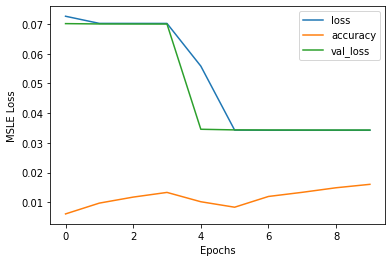

In [141]:
plt.plot(grid.history['loss'])
plt.plot(grid.history['accuracy'])
plt.plot(grid.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss','accuracy', 'val_loss'])
plt.show()  

### Detect Anomalies on test data  
- Anomalies are data points where the reconstruction loss is higher 
- To calculate the reconstruction loss on test data, predict the test data and calculate the mean square error between the test data and the reconstructed test data. 

#### Predictions and Computing Reconstruction Error

In [142]:
test_x_predictions = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions,2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)  
error_df.head()

,Reconstruction_error,A
Timestamp,,
2016-01-22 00:22:20,0.130490,0.0
2016-01-05 10:09:45,0.130490,0.0
2015-12-27 14:28:15,0.172126,0.0
2016-01-30 20:48:15,0.130490,0.0
2015-12-29 06:34:40,0.173014,1.0


In [143]:
# find the maximum of each column using reconstruction error 
maxValues = error_df.max()
 
print(maxValues)  

Reconstruction_error    0.456286
A                       1.000000
dtype: float64


In [144]:
# finding the number of anomalies using highest reconstruction Error 

outliers = error_df.index[error_df.Reconstruction_error >0.45].tolist()  
number_of_outliers = len(outliers) 
print("Number of elements in the anomalies: ", number_of_outliers)   

Number of elements in the anomalies:  266


In [145]:
# To identify the maximum and minimum data point for identifying bins 
import tensorflow as tf 
# reconstruction loss for normal test data
#reconstructions = model.predict(normal_test_data)
train_loss1 = tf.keras.losses.mae(test_x_predictions, x_good_test)


trainloss1=pd.DataFrame(train_loss1)
#trainloss.describe()
#trainloss.to_csv(r'/home/jovyan/trainloss.csv',index=False) 
trainloss1.describe()  
 

,0
count,141552.000000
mean,0.143576
std,0.022488
min,0.092738
25%,0.140602
50%,0.140602
75%,0.140602
max,0.388318


Text(0.5, 1.0, 'bins - loss distribution = 27')

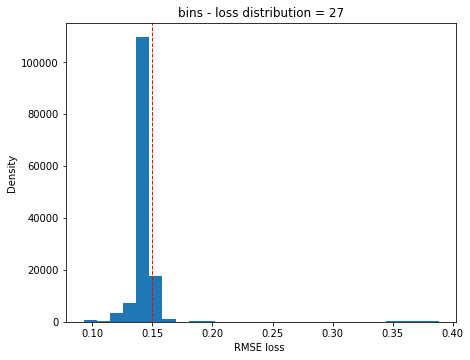

In [156]:
# rules-of-thumb to identify the number of bins Freedman–Diaconis rule 
trainloss1=pd.DataFrame(trainloss1) 
q1 = trainloss1.quantile(0)
q3 = trainloss1.quantile(1)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(trainloss1) ** (1 / 3))
bin_count = int(np.ceil((trainloss1.max() - trainloss1.min()) / bin_width))
fig = plt.figure(figsize=(7,5.5))
plt.hist(train_loss1, bins = bin_count)  

plt.axvline(0.15,0, 9000,color='red', linestyle='dashed', linewidth=1) 
plt.xlabel('RMSE loss ')
plt.ylabel('Density')
plt.title(f'bins - loss distribution = {bin_count}') 

### Model Interpretability

In [147]:
# change X_tes_scaled to pandas dataframe
data_n = pd.DataFrame(x_good_test, index= test_y.index)#, columns=numerical_cols) 


In [148]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = model.predict(initial_pt)
    
    return abs(np.array(initial_pt - reconstrcuted_pt)[0]) 

In [149]:
outliers = error_df.index[error_df.Reconstruction_error > 0.15].tolist()  
number_of_outliers = len(outliers) 
print("Number of elements in the anomalies: ", number_of_outliers)  

Number of elements in the anomalies:  25773


<Figure size 1296x720 with 0 Axes>

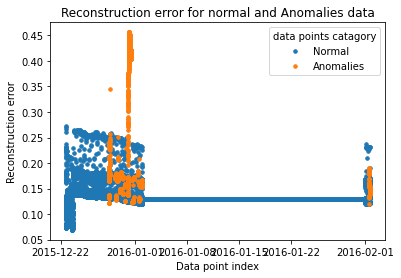

In [150]:
# visualize the anomaly points in the dataset with 2D 
plt.figure(figsize=(18,10))
threshold_fixed = 0.15
groups = error_df.groupby('A')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomalies" if name == 1 else "Normal")
ax.legend(title='data points catagory')
plt.title("Reconstruction error for normal and Anomalies data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index") 
 
plt.savefig('SWaT_AE_5sed.png') 

#### Calculate RMSE and MAE 

In [151]:
# Define a function to calculate MAE and RMSE
errors = test_x_predictions - x_good_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('The performance  of autoencoder'+ ':') 
print('')
print('Mean Absolute Error: {:.4f}'.format(mae)) 
print('Mean Square Error:{:.4f}' .format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('')  

The performance  of autoencoder:

Mean Absolute Error: 0.1436
Mean Square Error:0.1399
Root Mean Square Error: 0.3740



In [153]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score 
threshold_fixed = 0.15
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show() 



# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['A'], error_df['pred']))
#print(" Recall: ",recall_score(error_df['A'], error_df['pred']))
#print(" Precision: ",precision_score(error_df['A'], error_df['pred']))
print(classification_report(error_df['A'], error_df['pred']))  

[[115504  23914]
 [   275   1859]]
 Accuracy:  0.8291158019667684
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91    139418
         1.0       0.07      0.87      0.13      2134

    accuracy                           0.83    141552
   macro avg       0.53      0.85      0.52    141552
weighted avg       0.98      0.83      0.89    141552



<Figure size 288x288 with 0 Axes>

#### Mean p-Powered Error for auto encoder 
- To enhance the perfomance of reall and precision 

In [1571]:
test_x_predictions = model.predict(x_good_test)#,verbose=1)
mse = np.mean(np.power(x_good_test - test_x_predictions, 4), axis=1)
error_df_mean_power = pd.DataFrame({'Reconstruction_error': mse,'A': test_y}, index=test_y.index)  
error_df_mean_power.head() 

,Reconstruction_error,A
Timestamp,,
2016-01-22 00:22:20,0.200568,0.0
2016-01-05 10:09:45,0.200568,0.0
2015-12-27 14:28:15,0.384422,0.0
2016-01-30 20:48:15,0.200568,0.0
2015-12-29 06:34:40,0.521478,1.0


In [1572]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score 
threshold_fixed = 0.45
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_mean_power.Reconstruction_error.values]
error_df_mean_power['pred'] =pred_y
conf_matrix = confusion_matrix(error_df_mean_power.A, pred_y)
plt.figure(figsize=(4, 4))

print(conf_matrix)
# sns.heatmap(conf_matrix, xticklabels=df1.A, yticklabels=df1.A, annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show() 

# print classification report
#print(classification_report(error_df.A, pred_y) 

# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df_mean_power['A'], error_df_mean_power['pred']))
# print(" Recall: ",recall_score(error_df['A'], error_df['pred']))
# print(" Precision: ",precision_score(error_df['A'], error_df['pred']))   
# print classification report
print(classification_report(error_df_mean_power['A'], error_df_mean_power['pred'])) 

[[117215  22203]
 [  1772    362]]
 Accuracy:  0.8306276138804114
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91    139418
         1.0       0.02      0.17      0.03      2134

    accuracy                           0.83    141552
   macro avg       0.50      0.51      0.47    141552
weighted avg       0.97      0.83      0.89    141552



<Figure size 288x288 with 0 Axes>

####  Using SMOTE Algorithm 

- The accuracy comes out to be 83  % but it is not our concern evalution techniques  
It demonstrates how biased the model is in favor of the majority class. It thus demonstrates that this paradigm is not the optimal one.

- We will now use various approaches for handling unbalanced data and evaluate the results for accuracy, precision, and recall.

In [1578]:
# !pip install imblearn

In [1583]:

# # import SMOTE module from imblearn library
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state = 2)
# X_train_res, y_train_res = sm.fit_resample(, error_df_mean_power['pred'].ravel())
  
# print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
# print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
# print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
# print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

### model bulding using Isolation forest  

#### Split the Data to train and Test 

In [1584]:
df1.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-22 16:00:00,0.894293,0.159184,0.731315,0.732954,0.073596,0.873447,0.462669,0.948655,0.181982,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:05,0.919888,0.158988,0.734017,0.732954,0.073596,0.873338,0.462797,0.948960,0.181607,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:10,0.966483,0.160211,0.736412,0.732954,0.073433,0.875225,0.462712,0.948797,0.181156,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:15,0.950592,0.159506,0.737886,0.732954,0.072778,0.875542,0.463665,0.949156,0.182387,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0
2015-12-22 16:00:20,0.922724,0.160702,0.741878,0.733212,0.072778,0.875188,0.462925,0.949156,0.183137,0.0,...,0.012461,0.000803,0.000797,0.002182,0.0,0.004448,0.0,0.005921,0.000142,0.0


In [1585]:
# Train test split (80/20 %) 
X_train, X_test, y_train, y_test = train_test_split(df1,df1['lablel'],test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
 

The number of records in the training dataset is 566208
The number of records in the test dataset is 141552


In [1586]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape) 

(566208, 26)
(141552, 26)
(566208,)
(141552,)


#### Hyperparameter tuning for 5 second logs using Isolation forest   

In [ ]:
from sklearn import model_selection 
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer, f1_score 
clf = IsolationForest(random_state=47)

param_grid = {'n_estimators': [5,10,20,30,40],#list(range(100, 800)),#, 5)), 
              'max_samples': [5,10,20,30,40], #list(range(100, 500)),#, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4],# 0.5], 
              'max_features': [5,10,15], 
              #'bootstrap': [True, False], 
              #'n_jobs': [5, 10, 20, 30]
             }

f1sc = make_scorer(f1_score, average='micro')

grid_search = model_selection.GridSearchCV(clf, 
                                                 param_grid,                                                  
                                                 refit=True,
                                                 scoring=f1sc,
                                                 cv=10, 
                                                 return_train_score=True)
#grid_dt_estimator.fit(X_train, X_test)

best_model = grid_search.fit(X_train.values, y_train) 

print('Optimum parameters', best_model.best_params_)    

#### Train Isolation Forest Model 

In [1587]:
# Model and performance
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

In [1588]:
# Train the isolation forest model
if_model = IsolationForest(n_estimators=10,max_samples=15,contamination=0.1,random_state=47).fit(X_train)
# Predict the anomalies
if_prediction = if_model.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
if_prediction = [1 if i==-1 else 0 for i in if_prediction]
 

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



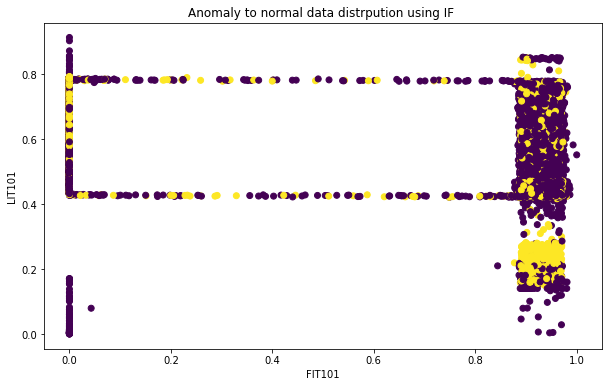

In [1589]:
# visualize the anomaly points in the dataset with 2D
plt.figure(figsize=(10,6)) 
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=if_prediction)
plt.title("Anomaly to normal data distrpution using IF ")
plt.xlabel("FIT101")
plt.ylabel("LIT101")
plt.show() 

#### determine anomaly score and identify anomalies

In [1590]:
result = X_test.copy()
result['scores'] = if_model.decision_function(X_test)
result['anomaly'] = if_model.predict(X_test)
result['anomaly'] = result['anomaly'].map( {1: 0, -1: 1} )
print(result['anomaly'].value_counts()) 

0    128831
1     12721
Name: anomaly, dtype: int64


In [1591]:
result.head() 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel,scores,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-22 00:22:20,0.000000,0.498886,0.057422,0.874510,0.063056,0.870626,0.042436,0.000000,0.669668,0.999839,...,0.976845,0.957729,0.966346,0.939548,0.240601,0.932436,0.000000,0.0,0.289827,0
2016-01-05 10:09:45,0.000000,0.498886,0.057422,0.874510,0.063056,0.870626,0.042436,0.000000,0.669668,0.999839,...,0.976845,0.957729,0.966346,0.939548,0.240601,0.932436,0.000000,0.0,0.289827,0
2015-12-27 14:28:15,0.932872,0.470776,0.939446,0.790563,0.147919,0.863460,0.058986,0.032010,0.798050,0.999806,...,0.981855,0.955714,0.961643,0.930765,0.343045,0.927975,0.000000,0.0,0.085274,0
2016-01-30 20:48:15,0.000000,0.498886,0.057422,0.874510,0.063056,0.870626,0.042436,0.000000,0.669668,0.999839,...,0.976845,0.957729,0.966346,0.939548,0.240601,0.932436,0.000000,0.0,0.289827,0
2015-12-29 06:34:40,0.964960,0.444086,0.862864,0.799700,0.174723,0.866426,0.446233,0.939918,0.746535,0.999806,...,0.947653,0.963974,0.969550,0.953179,0.242481,0.950442,0.000021,1.0,0.040212,0


In [1592]:
anomaly = result.loc[result['anomaly'] == 1]
anomaly.head(5) 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel,scores,anomaly
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-25 12:22:45,0.962194,0.453131,0.938709,0.791185,0.148828,0.867469,0.443629,0.941866,0.775053,0.999806,...,0.936835,0.968238,0.974415,0.956148,0.320489,0.957823,0.000036,0.0,-0.010153,1
2015-12-28 12:49:55,0.000000,0.784957,0.915679,0.816172,0.116882,0.000000,0.434606,0.941267,0.714680,0.999839,...,0.951184,0.960247,0.970158,0.935538,0.507519,0.933069,0.000071,0.0,-0.030927,1
2015-12-29 08:59:40,0.935498,0.448917,0.870540,0.800407,0.168635,0.865392,0.445678,0.938645,0.755754,0.999839,...,0.937632,0.968137,0.971253,0.955585,0.418233,0.952989,0.000071,0.0,-0.010153,1
2015-12-23 04:02:05,0.960952,0.424772,0.865320,0.787903,0.524041,0.865746,0.438406,0.935903,0.654622,0.000000,...,0.925807,0.972502,0.980862,0.959193,0.275376,0.962771,0.000036,0.0,-0.030927,1
2015-12-23 22:26:10,0.939435,0.464088,0.819259,0.786166,0.171270,0.860222,0.439872,0.938482,0.756864,0.999839,...,0.933741,0.969917,0.975956,0.958780,0.324248,0.961798,0.000036,0.0,-0.010153,1


In [1593]:
# extract the anomaly points in the form of CSV 
#anomaly.to_csv(r'/home/jovyan/isolationanomalies.csv',index=False) 

In [1594]:
anomaly_index = list(anomaly.index)  

In [1595]:
raw_anomaly = df1.loc[anomaly_index]  

In [1596]:
raw_anomaly.head()
 

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601,lablel
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-25 12:22:45,0.962194,0.453131,0.938709,0.791185,0.148828,0.867469,0.443629,0.941866,0.775053,0.999806,...,0.010278,0.979818,0.936835,0.968238,0.974415,0.956148,0.320489,0.957823,0.000036,0.0
2015-12-28 12:49:55,0.000000,0.784957,0.915679,0.816172,0.116882,0.000000,0.434606,0.941267,0.714680,0.999839,...,0.012370,0.986984,0.951184,0.960247,0.970158,0.935538,0.507519,0.933069,0.000071,0.0
2015-12-29 08:59:40,0.935498,0.448917,0.870540,0.800407,0.168635,0.865392,0.445678,0.938645,0.755754,0.999839,...,0.010187,0.978417,0.937632,0.968137,0.971253,0.955585,0.418233,0.952989,0.000071,0.0
2015-12-23 04:02:05,0.960952,0.424772,0.865320,0.787903,0.524041,0.865746,0.438406,0.935903,0.654622,0.000000,...,0.009186,0.971165,0.925807,0.972502,0.980862,0.959193,0.275376,0.962771,0.000036,0.0
2015-12-23 22:26:10,0.939435,0.464088,0.819259,0.786166,0.171270,0.860222,0.439872,0.938482,0.756864,0.999839,...,0.008004,0.977411,0.933741,0.969917,0.975956,0.958780,0.324248,0.961798,0.000036,0.0


In [1597]:
df1["FIT101"].value_counts() 

0.000000    574204
0.966905        47
0.932146        45
0.891339        42
0.966108        42
             ...  
0.959475         1
0.793929         1
0.243783         1
0.952490         1
0.938802         1
Name: FIT101, Length: 19357, dtype: int64

In [1598]:
raw_anomaly["FIT101"].value_counts() 
#raw_anomaly["FIT101"].value_counts().sort_values().plot(kind = 'barh')  

0.000000    6110
0.891457       6
0.890847       5
0.966788       5
0.962756       5
            ... 
0.908731       1
0.893144       1
0.918411       1
0.891433       1
0.911121       1
Name: FIT101, Length: 4939, dtype: int64

In [1599]:
raw_anomaly["LIT101"].value_counts()  

0.787475    13
0.787895    12
0.787323    10
0.787270    10
0.786493    10
            ..
0.723924     1
0.267078     1
0.443041     1
0.789118     1
0.432737     1
Name: LIT101, Length: 9744, dtype: int64

In [1600]:
raw_anomaly["AIT202"].value_counts()  

0.786145    74
0.783678    73
0.785394    72
0.786037    68
0.784858    66
            ..
0.782134     1
0.789920     1
0.812247     1
0.813362     1
0.781855     1
Name: AIT202, Length: 4550, dtype: int64

#### perfomance evalution using RMSE  

In [1601]:
# Define a function to calculate MAE and RMSE
errors = if_prediction - y_test
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()

print('The performance  of autoencoder'+ ':') 
print('')
print('Mean Absolute Error: {:.4f}'.format(mae)) 
print('Mean Square Error:{:.4f}' .format(mse))
print('Root Mean Square Error: {:.4f}'.format(rmse))
print('')  

The performance  of autoencoder:

Mean Absolute Error: 0.0894
Mean Square Error:0.0894
Root Mean Square Error: 0.2990



#### Confusion matrix  

In [1602]:
# Check the model performance
print(classification_report(y_test, if_prediction)) 

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    139418
         1.0       0.09      0.51      0.15      2134

    accuracy                           0.91    141552
   macro avg       0.54      0.72      0.55    141552
weighted avg       0.98      0.91      0.94    141552

